<a href="https://colab.research.google.com/github/RaisaAnika/model-confidence_CIFAR10/blob/main/CIS545_Fall22_ModelConfidence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIFAR-10 Model and Some Useful Starter Code

This starter code is to help you have a CIFAR-10 model that is trained on the whole dataset. You will also find some helper functions for splitting the dataset into $n$ disjoint sets (from which you can train individual models that will serve in the ensemble).

The CIFAR10 dataset contains 60K color images in 10 classes, with 6K images in each class. The dataset is divided into 50K training images and 10K testing images. The classes are mutually exclusive and there is no overlap between them. The 10 classes are ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck'].




In [18]:
import tensorflow as tf
from keras.models import Model   
from keras.layers import *
import matplotlib.pyplot as plt

In [44]:
!pip install tensorflow_privacy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 301 kB 4.2 MB/s 
     |████████████████████████████████| 5.7 MB 28.8 MB/s 
     |████████████████████████████████| 11.2 MB 47.3 MB/s 
     |████████████████████████████████| 89 kB 9.4 MB/s 
     |████████████████████████████████| 60 kB 8.1 MB/s 
     |████████████████████████████████| 301 kB 69.8 MB/s 
     |████████████████████████████████| 287 kB 60.5 MB/s 
     |████████████████████████████████| 287 kB 61.5 MB/s 
     |████████████████████████████████| 9.5 MB 30.3 MB/s 
     |████████████████████████████████| 4.2 MB 34.2 MB/s 
     |████████████████████████████████| 11.5 MB 24.8 MB/s 
     |████████████████████████████████| 82 kB 674 kB/s 
     |████████████████████████████████| 126 kB 62.4 MB/s 
  Attempting uninstall: absl-py
    Found existing installation: absl-py 1.3.0
    Uninstalling absl-py-1.3.0:
      Successfully uninstalled absl-py-1.

In [45]:
!pip install tensorflow-privacy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [49]:
###Tensorflow attack libraries

from tensorflow_privacy.privacy.membership_inference_attack import membership_inference_attack as mia
#from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack as mia 
from tensorflow_privacy.privacy.membership_inference_attack.data_structures import AttackInputData
from tensorflow_privacy.privacy.membership_inference_attack.data_structures import SlicingSpec
from tensorflow_privacy.privacy.membership_inference_attack.data_structures import AttackType

In [19]:
# download CIFAR-10 dataset and split it into train and test set
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()


In [20]:
print(x_train.shape[0])

50000


In [21]:
print(x_test.shape[0])

10000


In [37]:
print(y_train)

[[6]
 [9]
 [9]
 ...
 [9]
 [1]
 [1]]


In [22]:
# normalze pixel values to be in the range [0,1] instead of [0, 255]
x_train, x_test= x_train/ 255.0, x_test / 255.0



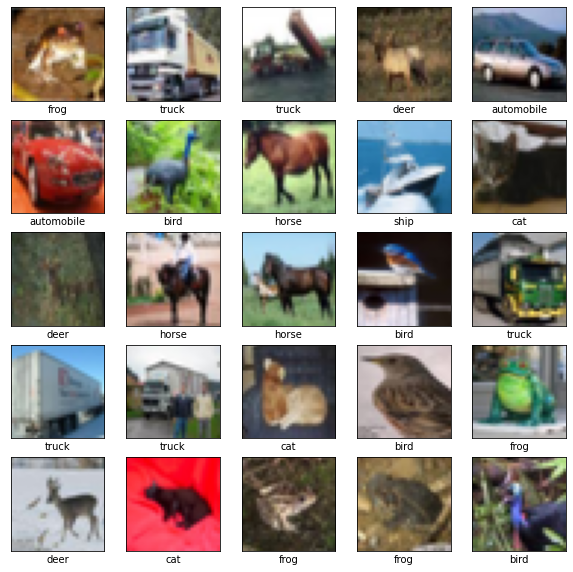

In [23]:
# let's check what individual samples in the training data look like just for verification

labels = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i])
    plt.xlabel(labels[y_train[i][0]])
plt.show()



In [24]:
def define_model():
  """ This model is fairly simple, feel free to play with this part in pursuit of a better accuracy architecture.
  """
  shape = (32, 32, 3)
  input = Input(shape=shape)
  x = Conv2D(32, (3, 3), activation='relu')(input)
  x = MaxPooling2D()(x)

  x = Conv2D(64, (3, 3), activation='relu')(x)
  x = MaxPooling2D()(x)

  x = Conv2D(64, (3, 3), activation='relu')(x)
  x = MaxPooling2D()(x)

  x = Flatten()(x)
  x = Dense(128, activation='relu')(x)
  x = Dense(10)(x)
  model = Model(input, x)
  return model

In [25]:
# check model summary
model = define_model()
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 4, 4, 64)          3692

In [26]:
# specify parameters
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# compile the model
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# train the model
history = model.fit(x_train, y_train,
                       validation_data=(x_test, y_test),
                       batch_size=128, 
                       epochs=10)
history

Epoch 1/10
391/391 [==============================] - 70s 177ms/step - loss: 1.6724 - accuracy: 0.3886 - val_loss: 1.3832 - val_accuracy: 0.5037
Epoch 2/10
391/391 [==============================] - 74s 190ms/step - loss: 1.2989 - accuracy: 0.5328 - val_loss: 1.2120 - val_accuracy: 0.5620
Epoch 3/10
391/391 [==============================] - 67s 172ms/step - loss: 1.1520 - accuracy: 0.5932 - val_loss: 1.1567 - val_accuracy: 0.5908
Epoch 4/10
391/391 [==============================] - 69s 177ms/step - loss: 1.0486 - accuracy: 0.6314 - val_loss: 1.0817 - val_accuracy: 0.6134
Epoch 5/10
391/391 [==============================] - 72s 183ms/step - loss: 0.9815 - accuracy: 0.6545 - val_loss: 1.0048 - val_accuracy: 0.6510
Epoch 6/10
391/391 [==============================] - 67s 172ms/step - loss: 0.9131 - accuracy: 0.6815 - val_loss: 0.9775 - val_accuracy: 0.6536
Epoch 7/10
391/391 [==============================] - 68s 174ms/step - loss: 0.8667 - accuracy: 0.6963 - val_loss: 0.9481 - val_ac

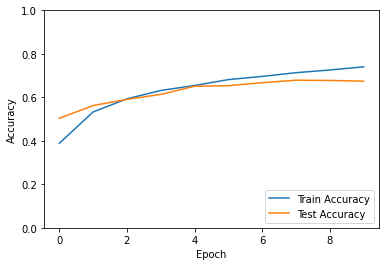

In [27]:
# evalaute model accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

In [28]:
# predict probabilities
import numpy as np
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])
predictions = probability_model.predict(x_test)




313/313 [==============================] - 5s 15ms/step


In [29]:
print(predictions)

[[6.8177998e-02 3.5559693e-03 9.7118290e-03 ... 1.5003289e-02
  3.0718663e-01 8.0331616e-02]
 [6.0094703e-02 1.4768550e-01 6.5683985e-06 ... 8.4549456e-06
  7.9116344e-01 1.0102760e-03]
 [3.4525126e-02 4.9522236e-01 8.4316148e-04 ... 5.8717985e-04
  3.9296275e-01 7.3555425e-02]
 ...
 [2.5762472e-04 1.6495232e-04 5.8329874e-03 ... 1.7974894e-01
  5.4712343e-04 1.2986946e-03]
 [2.8323275e-01 5.6273669e-01 4.4139852e-03 ... 6.1895777e-03
  3.1434454e-03 1.0086924e-01]
 [2.5624648e-05 5.4649594e-05 8.2984951e-04 ... 9.6923578e-01
  1.0557388e-06 1.7810547e-05]]


In [30]:
index =0
for p in predictions:
  print( p, np.argmax(p),y_test[index])
  index+=1

Streaming output truncated to the last 5000 lines.
 6.2735349e-02 3.2317176e-01 8.9910209e-02 4.8539277e-05 1.3142691e-02] 6 [6]
[0.29140323 0.00104505 0.01138483 0.01245127 0.01904604 0.00279482
 0.00393469 0.00094858 0.6531004  0.00389104] 8 [0]
[5.3250091e-04 2.2868693e-04 3.6580123e-03 2.6326682e-02 2.7808657e-01
 1.3783389e-01 1.2720433e-03 5.5157751e-01 2.3926312e-05 4.6017225e-04] 7 [5]
[0.11325138 0.03462395 0.02592452 0.02860122 0.00734476 0.26020965
 0.05056264 0.01473447 0.16373982 0.30100763] 9 [0]
[8.3942609e-03 1.3649477e-04 1.4614016e-03 5.4742726e-03 1.9848857e-02
 1.5225308e-02 4.2176901e-04 9.4686770e-01 9.1887492e-04 1.2510716e-03] 7 [7]
[6.5766186e-02 6.5762632e-02 9.3900695e-02 5.1950710e-03 3.7616558e-02
 2.5578097e-03 5.0441511e-03 6.9499576e-01 3.4862827e-04 2.8812507e-02] 7 [7]
[4.8445523e-02 4.0513201e-04 1.9663518e-02 1.6796121e-02 6.2195822e-03
 1.6935108e-02 2.9510083e-03 7.9718119e-01 4.6580273e-04 9.0936862e-02] 7 [7]
[5.6940224e-04 1.6159071e-02 2.631240

In [31]:
predictions_trained_data = probability_model.predict(x_train)

1563/1563 [==============================] - 24s 15ms/step


In [32]:
print(predictions_trained_data)

[[1.84178789e-04 2.96337967e-04 1.14534451e-02 ... 8.34546611e-02
  1.82190488e-05 1.68082970e-05]
 [1.19027914e-03 1.72222161e-03 1.33443958e-04 ... 4.83040756e-04
  4.81975498e-04 9.95965838e-01]
 [8.52879882e-02 1.11583835e-02 8.55861977e-03 ... 2.28426438e-02
  6.11782959e-03 8.56685162e-01]
 ...
 [1.24175884e-01 2.26148311e-02 1.39337627e-03 ... 3.07512116e-02
  1.42470762e-01 6.76076829e-01]
 [2.36107916e-01 5.00741243e-01 5.79391955e-04 ... 2.35728221e-03
  3.27770524e-02 2.26517230e-01]
 [4.98355627e-01 1.95561215e-01 1.12244552e-02 ... 6.97184587e-03
  2.87881363e-02 2.45597571e-01]]


In [35]:
#Attack Model Build-up

prob_train = predictions_trained_data
prob_test= predictions


In [38]:
yt=y_train[0:5000]
ys=y_test[5000:10000]

In [39]:
(unique, counts) = np.unique(ys, return_counts=True)
frequencies = np.asarray((unique, counts)).T
frequencies

array([[  0, 512],
       [  1, 495],
       [  2, 488],
       [  3, 503],
       [  4, 493],
       [  5, 512],
       [  6, 509],
       [  7, 505],
       [  8, 496],
       [  9, 487]])

In [50]:
# define what variables our attacker should have access to

attack_input = AttackInputData(
  logits_train = prob_train,
  logits_test = prob_test,
  #loss_train = loss_train,
  #loss_test = loss_test,
  labels_train =yt,
  labels_test =ys
)

In [51]:
attack_input

AttackInputData(logits_train=array([[1.84178789e-04, 2.96337967e-04, 1.14534451e-02, ...,
        8.34546611e-02, 1.82190488e-05, 1.68082970e-05],
       [1.19027914e-03, 1.72222161e-03, 1.33443958e-04, ...,
        4.83040756e-04, 4.81975498e-04, 9.95965838e-01],
       [8.52879882e-02, 1.11583835e-02, 8.55861977e-03, ...,
        2.28426438e-02, 6.11782959e-03, 8.56685162e-01],
       ...,
       [1.24175884e-01, 2.26148311e-02, 1.39337627e-03, ...,
        3.07512116e-02, 1.42470762e-01, 6.76076829e-01],
       [2.36107916e-01, 5.00741243e-01, 5.79391955e-04, ...,
        2.35728221e-03, 3.27770524e-02, 2.26517230e-01],
       [4.98355627e-01, 1.95561215e-01, 1.12244552e-02, ...,
        6.97184587e-03, 2.87881363e-02, 2.45597571e-01]], dtype=float32), logits_test=array([[6.8177998e-02, 3.5559693e-03, 9.7118290e-03, ..., 1.5003289e-02,
        3.0718663e-01, 8.0331616e-02],
       [6.0094703e-02, 1.4768550e-01, 6.5683985e-06, ..., 8.4549456e-06,
        7.9116344e-01, 1.0102760e-03]

In [52]:
# how should the data be sliced
slicing_spec = SlicingSpec(
    entire_dataset = True,
    by_class = False,
    by_percentiles = False,
    by_classification_correctness = True)

In [54]:
# define the type of attacker model that we want to use
attack_type = [
    AttackType.MULTI_LAYERED_PERCEPTRON
]

In [55]:
attacks_result_probD = mia.run_attacks(attack_input=attack_input,
                                 slicing_spec=slicing_spec,
                                 attack_types=attack_type)

ValueError: ignored